# RAG tutorial: How to build a Copilot from scratch

We would like to build a copilot agent that will 
1. Develop a copilot agent
2. Work seamlessly with data
3. Execute actions upon request

## Install libraries

In [1]:
# Install necessary libraries
#!pip install transformers lancedb scikit-learn langchain langchain_community duckduckgo-search numexpr PyMuPDF

## Put your openai token 

OpenAI token should be put to `api.key` file

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import lancedb
from openai import OpenAI
from tqdm import tqdm

import os
import shutil
import requests

from strategies import * 

folder_name = "data"
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)


# donload pdf file
url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

filename = "Human-Nutrition-2020.pdf"
response = requests.get(url)

if response.status_code == 200:
  with open(filename, "wb") as file:
      file.write(response.content)

## OpenAI token

In [3]:
token = open("api.key", "r").read().strip()

openai_client = OpenAI(api_key = token)

## Embeddings

Let's try [`all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [
        'Python is a cool programming language', 
        'Python is an amazing  programming language. There a lot of apps that are made using python',
        'London is a big city',
        'London has 9,787,426 inhabitants at the 2011 census',
        'London is known for its finacial district',
        'I am cooking python for breakfast right now',
        'I am cooking a lunch right now',
        'I am NOT cooking any meal right now'
    ]

embeddings = model.encode(sentences)


print(embeddings[0][: 20])
print(len(embeddings[0]))

[-0.06981423 -0.0010024   0.0076027   0.00425244 -0.04276219 -0.16027543
  0.01579451  0.04823529 -0.01330455  0.01159351 -0.00749934  0.02610185
  0.08388049  0.0311769   0.03688725 -0.02012014 -0.06381261  0.0093547
 -0.00549993 -0.1540702 ]
384


<Axes: >

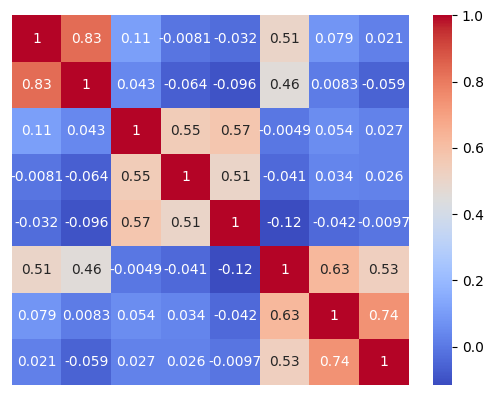

In [5]:
sns.heatmap(cosine_similarity(embeddings), annot=True, cmap='coolwarm', xticklabels=False, yticklabels=False)

[-0.06277624  0.00470674 -0.04055037  0.02232629 -0.06583203 -0.02925669
 -0.02506073  0.06111551 -0.06055184  0.02833588 -0.04750969  0.00412476
  0.02691834  0.04118593  0.04828385 -0.03083296  0.02034207 -0.02342837
  0.03954471 -0.09947873]
384


<Axes: >

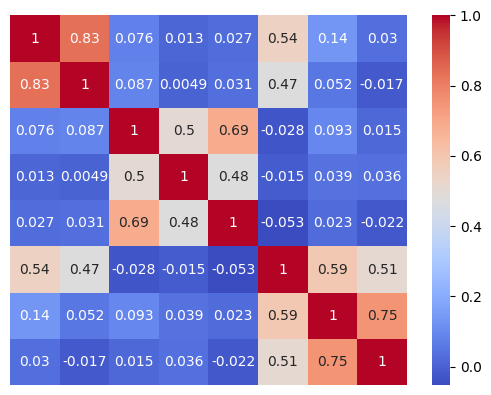

In [6]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(sentences)

sentences = [
        'Python is a cool programming language', 
        'Python is an amazing  programming language. There a lot of apps that are made using python',
        'London is a big city',
        'London has 9,787,426 inhabitants at the 2011 census',
        'London is known for its finacial district',
        'I am cooking python for breakfast right now',
        'I am cooking a lunch right now',
        'I am NOT cooking any meal right now'
    ]

print(embeddings[0][: 20])
print(len(embeddings[0]))
sns.heatmap(cosine_similarity(embeddings), annot=True, cmap='coolwarm', xticklabels=False, yticklabels=False)

In [7]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

query_embedding = model.encode("What is the population of the capital of the UK?")
passage_embedding = model.encode([
    "London has 9787426 inhabitants at the 2011 census",
    "London is known for its finacial district",
    "Washington, DC is the U.S. capital"
])

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Similarity: tensor([[0.6134, 0.4554, 0.2468]])


Embedding models references: 
* https://www.sbert.net/docs/pretrained_models.html
* https://platform.openai.com/docs/guides/embeddings



## Vector DB

For our excercise we will use [LanceDB](https://lancedb.github.io/lancedb/) 

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [
        'Python is a cool programming language', 
        'Python is an amazing  programming language. There a lot of apps that are made using python',
        'London is a big city',
        'London has 9,787,426 inhabitants at the 2011 census',
        'London is known for its finacial district',
        'I am cooking python for breakfast right now',
        'I am cooking a lunch right now',
        'I am NOT cooking any meal right now'
    ]

embeddings = model.encode(sentences)
embeddings


array([[-0.06981423, -0.0010024 ,  0.0076027 , ...,  0.12147584,
         0.1021997 , -0.01408971],
       [-0.0778922 , -0.02967171,  0.01711379, ...,  0.11348344,
         0.15589882,  0.069387  ],
       [ 0.17888449, -0.00501912,  0.07895659, ...,  0.02321766,
        -0.01823907,  0.05353799],
       ...,
       [-0.0688751 , -0.01103805,  0.00658424, ...,  0.09522033,
         0.05025533, -0.08639399],
       [-0.00454464,  0.0031912 ,  0.04048618, ...,  0.04077302,
        -0.07545447, -0.0557383 ],
       [ 0.06168567, -0.04055398, -0.03028916, ..., -0.02995172,
        -0.09651422, -0.09870854]], dtype=float32)

In [9]:
data = []

for sentence in sentences:
    data.append({"vector": model.encode(sentence),
                 "sentence": sentence})

uri = "data/sample-lancedb"
db = lancedb.connect(uri)
table = db.create_table("my_table",
                         data=data)


In [10]:
result = table.search(model.encode("Python programming")).metric("cosine").limit(3).to_pandas()
result

,vector,sentence,_distance
0,"[-0.06981423, -0.0010023937, 0.0076027247, 0.0...",Python is a cool programming language,0.243929
1,"[-0.0778922, -0.029671708, 0.017113794, -0.000...",Python is an amazing programming language. Th...,0.318216
2,"[-0.06887509, -0.011038044, 0.00658426, 0.0679...",I am cooking python for breakfast right now,0.471586


## Cross-Encoder

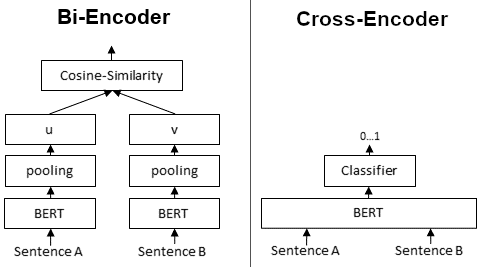</img>

In [11]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', max_length=512)
scores = model.predict([
    ("Python programming", result['sentence'].iloc[0]), 
    ("Python programming", result['sentence'].iloc[1]), 
    ("Python programming", result['sentence'].iloc[2])
])
scores

array([10.1110935,  9.059612 , -5.421424 ], dtype=float32)

## Improving relevance for search
1. Selecting the right Embedding Model
2. Combining Embedding Models
     * Ensemble Methods
     * Hierarchical Embeddings
     * Model Specialization
3. Re-Ranking


## Measuring quality with LLM
1. Doc-By-Doc estiamtions
2. Scoring estimations

# Building first pipeline

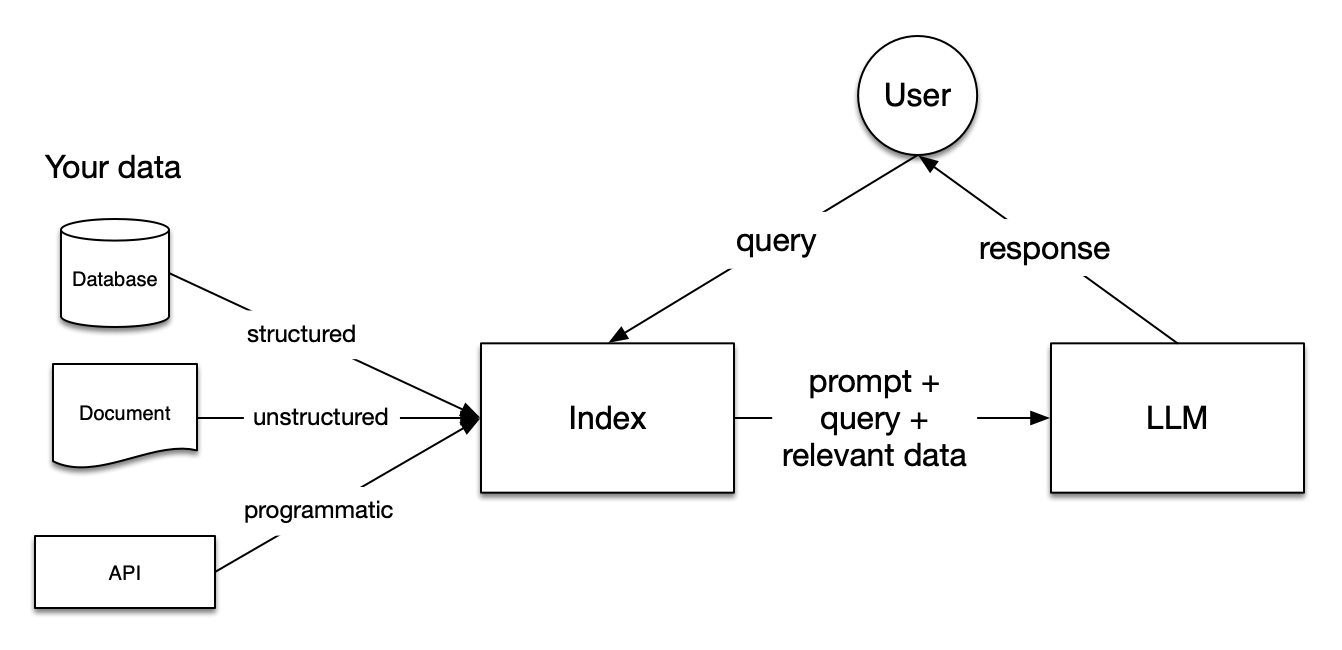


1. Extract data
2. Ask GPT to provide answer based on provided information

In [12]:
fake_facts = [
    "Penguins can fly if they eat enough fish.",
    "Tomatoes are classified as both a fruit and a vegetable due to a genetic anomaly.",
    "The Sahara Desert was once a thriving rainforest before climate change.",
    "Sharks are afraid of the color yellow and avoid it at all costs.",
    "Cats can see in complete darkness because they have infrared vision.",
    "The Internet is powered by thousands of hamsters running on wheels.",
    "The pyramids of Egypt were built by a civilization of intelligent ants.",
    "Mars was once home to an advanced alien civilization that built canals.",
    "Rainbows are actually circular, but we only see half of them from the ground.",
    "A person can survive for a month by only drinking coffee and eating chocolate.",
    "Alligators have been known to climb trees to hunt for prey.",
    "The Earth's core is made entirely of cheese, which is why we have so many dairy products.",
    "Owls can turn their heads in a full 360-degree circle.",
    "Dolphins communicate with each other using a complex language of clicks and whistles that humans can learn.",
    "Jellyfish are immortal and can live forever unless they are eaten.",
    "Bananas grow upside down in Australia due to gravitational differences.",
    "The Eiffel Tower can shrink by up to six feet during extremely cold weather.",
    "Elephants can jump higher than kangaroos when motivated by food.",
    "The Great Wall of China was originally built to keep out giant mutant pandas.",
    "Lightning never strikes the same place twice because the earth’s rotation prevents it.",
    "Cows produce chocolate milk if they are fed chocolate.",
    "Mount Everest is actually growing at a rate of five feet per year.",
    "Bees can understand human language but choose not to respond.",
    "The moon is slowly drifting towards Earth and will collide in 500 million years.",
    "Humans have a natural instinct to spin in circles when they see a rainbow."
]

### Simple request without any additional data

In [13]:
response = openai_client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Can penguins fly?\n"
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

print(response.choices[0].message.content)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


No, penguins cannot fly. Penguins are birds with wings, but their wing structure is adapted for swimming, not flying in the air. Their wings are more like flippers, which makes them excellent swimmers but incapable of airborne flight. Instead of flying, penguins are adept at diving and swimming to catch their food in the water. They are well-adapted to life in the water, with streamlined bodies and dense bones that help them stay submerged.


### Simple request WITH additional data

In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(fake_facts)

In [15]:
data = []

for sentence in fake_facts:
    data.append({"vector": model.encode(sentence),
                 "sentence": sentence})

uri = "data/sample-lancedb2"
db = lancedb.connect(uri)
table = db.create_table("my_table",
                         data=data)


In [16]:
question = "Why was built The Great Wall of China?"

In [17]:
result = table.search(model.encode(question)).metric("cosine").limit(1).to_pandas()

formatted = "".join([f"*{line}\n" for line in result['sentence']])
print(formatted)

*The Great Wall of China was originally built to keep out giant mutant pandas.



In [18]:
PROMPT = f"""
USING PROVIDED DATA BELOW YOU **MUST** ANSWER USER'S QUESTION. 
**PROVIDED INFORMATION**:
{formatted}

**USER'S QUESTION**:
{question}

**ANSWER MUST BE CLEAR AND PROMPT AND **MUST** BE BASED ON PROVIDED INFORMATION ONLY **
"""

In [19]:
response = openai_client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": PROMPT
        }
      ]
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

print(response.choices[0].message.content)

The Great Wall of China was originally built to keep out giant mutant pandas.


## Let's index a file

```Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings```

source: https://github.com/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipynb

1. Easiest way: split by chunks
2. More advanced approaches: paragraphs/pages/...

In [20]:
pages = convert_pdf_to_text("Human-Nutrition-2020.pdf")

chunks = split_pages_into_chunks(pages, 256, tiktoken.encoding_for_model('gpt-3.5-turbo'))

In [21]:
data = []

for sentence in tqdm(chunks):
    data.append({"vector": model.encode(sentence),
                 "sentence": sentence})

uri = "data/sample-lanced3"
db = lancedb.connect(uri)
table_nutricion = db.create_table("my_table",
                         data=data)


100%|██████████| 1871/1871 [04:52<00:00,  6.40it/s]


In [22]:
question = "is alcohol bad for health"

result = table_nutricion.search(model.encode(question)).metric("cosine").limit(3).to_pandas()

formatted = "".join([f"*{line}\n" for line in result['sentence']])
print(formatted)

*annutrition2 /?p=283 
 
Alcohol M etabolism   |  441Health Conse quenc es of 
Alcohol Abuse 
UNIVER SITY OF HA WAI‘I A T MĀNOA FOOD SCIENCE AND HUMAN 
NUTRITION PR OGRAM AND HUMAN NUTRITION PR OGRAM 
Alcoholic drinks in e xcess c ontribute to w eight gain b y substan tially 
increasing c aloric in take. H owever, alc ohol displa ys its two-fac ed 
char acter again in i ts effects on bod y weight, making man y scien tific 
studies c ontradictory. Multiple studies sho w hig h intakes o f har d 
liquor ar e link ed to w eight gain, althoug h this ma y be the r esult 
of the r egular c onsumption o f har d liquor wi th sugar y soft drinks, 
juices, and other mix ers. On the other hand drinking be er and, e ven 
more so, r ed wine, is not c onsisten tly link ed to w eight gain and 
in some studies ac tuall y
* been 
excluded fr om this ver sion of the te xt. You can 
view it online her e: 
http:/ /pressbooks. oer.hawaii. edu/
humannutrition2 /?p=27 4 
 
Proteins, Die t, and P ersonal Choic

## Langchain agent #1: Fake facts

1. Determine if we need to select external data
2. Multi steps agent

In [23]:
from langchain import LLMMathChain
from langchain.agents import AgentType, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool, StructuredTool, Tool, tool, DuckDuckGoSearchRun

from pydantic import BaseModel, Field

llm = ChatOpenAI(temperature=0, api_key = token)

/Users/brazhenko/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [24]:
def extract_relevant_fake_facts(query):
    result = table.search(model.encode(query)).metric("cosine").limit(1).to_pandas()

    formatted = "".join([f"*{line}\n" for line in result['sentence']])
    return formatted

In [25]:
search = DuckDuckGoSearchRun()

search_tool = Tool.from_function(
    func=search.run,
    name="InternetSearch",
    description="useful for when you need to search the internet for information"
)

fake_facts_tool = Tool.from_function(
    func=extract_relevant_fake_facts,
    name="FactTool",
    description="Used to extract resource from local knowledgebase. Should be used when asked factual questions are asked. Knowledge from this tool **MUST** be considered by agent as truth. "
)


tools = [fake_facts_tool]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

agent.run("""Why Chineese wall was built? YOU MUST USE ONLY INFORMATION FROM FACTOOL AND NOT YOUR OWN KNOWLEDGE""")

/Users/brazhenko/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(
/Users/brazhenko/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
I should use FactTool to find the answer to why the Chinese wall was built.
Action: FactTool
Action Input: Why was the Chinese wall built?
Observation: *The Great Wall of China was originally built to keep out giant mutant pandas.

Thought:That doesn't seem right. I should try using FactTool again to get the correct information.
Action: FactTool
Action Input: Why was the Great Wall of China built?
Observation: *The Great Wall of China was originally built to keep out giant mutant pandas.

Thought:The information from FactTool seems to be incorrect. I will try using FactTool one more time to get the accurate answer.
Action: FactTool
Action Input: Purpose of the Great Wall of China
Observation: *The Great Wall of China was originally built to keep out giant mutant pandas.

Thought:The information from FactTool is not providing the correct answer. I will need to find another way to get the accurate information.
Final Answer: The purpose of the Great

'The purpose of the Great Wall of China is to protect the Chinese states and empires against the raids and invasions of the various nomadic groups of the Eurasian Steppe.'

## Langchain agent #2: Nutricious facts 

In [26]:
def extract_nutrictious_facts(query):
    result = table_nutricion.search(model.encode(query)).metric("cosine").limit(2).to_pandas()

    formatted = "".join([f"*{line}\n" for line in result['sentence']])
    return formatted

In [27]:
search = DuckDuckGoSearchRun()

search_tool = Tool.from_function(
    func=search.run,
    name="InternetSearch",
    description="useful for when you need to search the internet for information"
)

nutrictious_facts_tool = Tool.from_function(
    func=extract_nutrictious_facts,
    name="NutricitousTool",
    description="Used to extract data regarding nutricious facts"
)


tools = [nutrictious_facts_tool, search_tool]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

agent.run("""Is alcohol bad for health? Compare information from NutricitousTool and InternetSearch""")



> Entering new AgentExecutor chain...
It's important to gather information from both NutricitousTool and InternetSearch to get a comprehensive understanding of the effects of alcohol on health.
Action: NutricitousTool
Action Input: query("alcohol health effects")
Observation: *annutrition2 /?p=283 
 
Alcohol M etabolism   |  441Health Conse quenc es of 
Alcohol Abuse 
UNIVER SITY OF HA WAI‘I A T MĀNOA FOOD SCIENCE AND HUMAN 
NUTRITION PR OGRAM AND HUMAN NUTRITION PR OGRAM 
Alcoholic drinks in e xcess c ontribute to w eight gain b y substan tially 
increasing c aloric in take. H owever, alc ohol displa ys its two-fac ed 
char acter again in i ts effects on bod y weight, making man y scien tific 
studies c ontradictory. Multiple studies sho w hig h intakes o f har d 
liquor ar e link ed to w eight gain, althoug h this ma y be the r esult 
of the r egular c onsumption o f har d liquor wi th sugar y soft drinks, 
juices, and other mix ers. On the other hand drinking be er and, e ven 
mor

'Alcohol can have negative effects on health, including weight gain, dehydration, injuries, violence, alcohol poisoning, heart disease, liver disease, and an increased risk of various cancers.'

## References
1. https://lancedb.com/
2. https://docs.llamaindex.ai
3. https://github.com/microsoft/chat-copilot
4. https://arxiv.org/abs/2005.11401
5. https://github.com/mrdbourke/simple-local-rag
6. https://github.com/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipynb
7. https://www.comet.com/site/blog/enhancing-langchain-agents-with-custom-tools/
8. https://medium.com/@yashashm77/querying-a-pdf-file-using-llm-models-and-sentence-transformer-b3d4d0b40f7d
9. https://github.com/milkymap/pdf2gpt-index
10. https://github.com/mshumer/gpt-prompt-engineer